In [28]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import (
        mean_absolute_error,
        mean_squared_error,
        mean_squared_log_error,
        r2_score,
)
%matplotlib inline

In [29]:
df = pd.read_csv("../input/Occupancy_Estimation_cleaned.csv")

# Cenário 2 - Outliers
Chega, então, o momento de lidar com os outliers. Existem diferentes métodos de deteção de outliers: *Z-Score, Quantile Filter, and IQR-distance from Median* são os mais comuns. *Z-Score* socorre-se da média e do desvio padrão, então, a avaliação dos outliers pode surgir enviesada. *Quantile Filter* é uma estratégia superior, mas leva à remoção de informação que pode ser essencial, resultando na remoção de dados importantes e na manutenção de outliers, podendo fazer o contrário do desejado. Então, consideramos que o *Z-score* é o que tem menos a oferecer, porque depende de medidas não robustas, falhando na deteção de outliers em datasets de pequeno tamanho. É, então, melhor utilizar a distância interquartil à mediana, como método de deteção. Para isso, utilizamos a seguinte função:

In [30]:
def detect_outliers_IQR(df):
   #Calculate the Q1:
   Q1 = np.percentile(df, 25)
   #Calculate the Q3:
   Q3 = np.percentile(df, 75)
   #Calculatedf_day1 the IQR:
   IQR=Q3-Q1
   # Upper bound
   upper = np.where(df >= (Q3+1.5*IQR))
   # Lower bound
   lower = np.where(df <= (Q1-1.5*IQR))
   #Outliers
   outliers = df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
   return outliers, upper, lower

* **S1_Temp**

<AxesSubplot: >

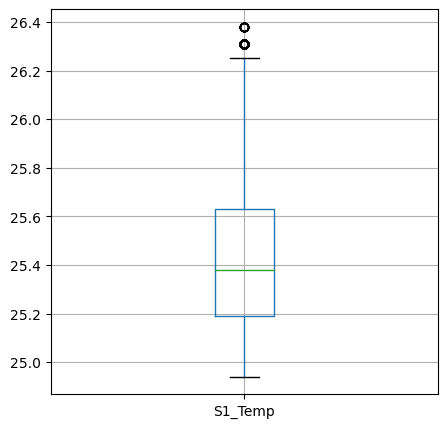

In [31]:
plt.figure(figsize= (5,5))
df.boxplot(column= "S1_Temp")

In [32]:
outliersS1, upperS1, lowerS1 = detect_outliers_IQR(df["S1_Temp"])

print("number of outliers: "+ str(len(outliersS1)))

print("max outlier value: "+ str(outliersS1.max()))

print("min of outliers: "+ str(outliersS1.min()))

print("Percentage of outliers: "+ str(len(outliersS1)/len(df) * 100))

number of outliers: 162
max outlier value: 26.38
min of outliers: 26.31
Percentage of outliers: 1.5993681508539834


In [33]:
df.drop(upperS1[0], inplace = True)

In [34]:
df.shape

(9967, 12)

* **S1_Light**

<AxesSubplot: >

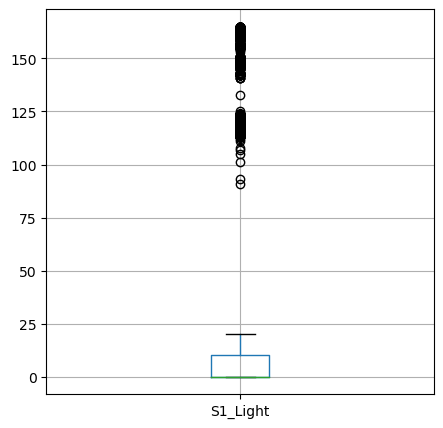

In [35]:
plt.figure(figsize= (5,5))
df.boxplot(column= "S1_Light")

In [36]:
outliersS1L, upperS1L, lowerS1L = detect_outliers_IQR(df['S1_Light'])

print("number of outliers: "+ str(len(outliersS1L)))

print("max outlier value: "+ str(outliersS1L.max()))

print("min of outliers: "+ str(outliersS1L.min()))

print("Percentage of outliers: "+ str(len(outliersS1L)/len(df) * 100))

number of outliers: 1565
max outlier value: 165
min of outliers: 91
Percentage of outliers: 15.701815992776162


Há um número considerável, averiguemos.

In [37]:
extreme_light1 = df[(df['S1_Light'] > outliersS1L.min()) & (df['S1_Light'] < outliersS1L.max())]
extreme_light1.head()

,S1_Temp,S1_Light,S1_Sound,S5_CO2,S6_PIR,Room_Occupancy_Count,day_of_month,week_day,month,year,hour,minute
0,24.94,121,0.08,390,0,1,22,4,12,2017,10,49
1,24.94,121,0.93,390,0,1,22,4,12,2017,10,50
2,25.00,121,0.43,390,0,1,22,4,12,2017,10,50
3,25.00,121,0.41,390,0,1,22,4,12,2017,10,51
4,25.00,121,0.18,390,0,1,22,4,12,2017,10,51


In [38]:
occ_not_0 = extreme_light1[extreme_light1['Room_Occupancy_Count'] > 0]
print(len(occ_not_0)/len(extreme_light1) * 100)

100.0


Todos os outliers representam situações onde a ocupação é superior a 0, ou seja, quando está alguém dentro da sala. É importantíssimo não remover pois contém conhecimento que ajuda o modelo a prever inclusive casos das classes minoritárias (ocupação igual a 1,2,3). Não vamos remover.

* **S1_Sound**

<AxesSubplot: >

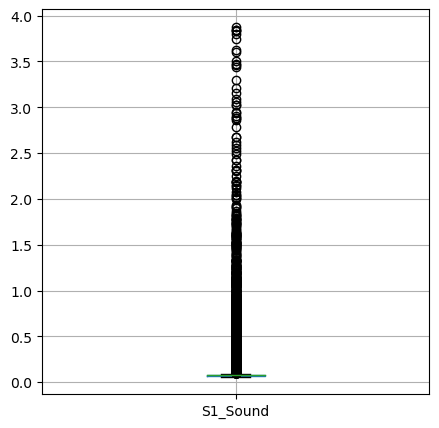

In [39]:
plt.figure(figsize= (5,5))
df.boxplot(column= "S1_Sound")

In [40]:
outliersS1S, uppeS1S, lowerS1S = detect_outliers_IQR(df['S1_Sound'])

print("number of outliers: "+ str(len(outliersS1S)))

print("max outlier value: "+ str(outliersS1S.max()))

print("min of outliers: "+ str(outliersS1S.min()))

print("Percentage of outliers: "+ str(len(outliersS1S)/len(df) * 100))

number of outliers: 1625
max outlier value: 3.88
min of outliers: 0.1
Percentage of outliers: 16.303802548409752


In [41]:
extreme_sound1 = df[(df['S1_Sound'] > outliersS1S.min()) & (df['S1_Sound'] < outliersS1S.max())]
occ_not_0 = extreme_sound1[extreme_sound1['Room_Occupancy_Count'] > 0]
print(len(occ_not_0)/len(extreme_sound1) * 100)

92.69406392694064


Neste caso, a maioria dos outliers é para o caso em que há pessoas na sala, por isso, vamos remover o ruído dos outliers alusivos ao caso em que existem 0 pessoas.

In [42]:
df.loc[(df['S1_Sound'] > outliersS1S.min()) & (df['S1_Sound'] < outliersS1S.max()) & df['Room_Occupancy_Count'] < 1, 'S1_Sound'] = df['S1_Sound'].mean() 

* S5_CO2

<AxesSubplot: >

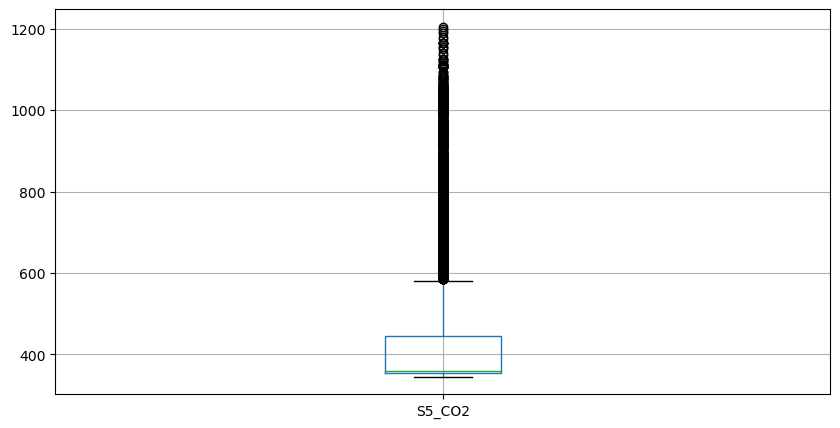

In [43]:
plt.figure(figsize= (10,5))
df.boxplot(column= "S5_CO2")

In [44]:
outliers, upper, lower = detect_outliers_IQR(df['S5_CO2'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min of outliers: "+ str(outliers.min()))

print("Percentage of outliers: "+ str(len(outliers)/len(df) * 100))

number of outliers: 1837
max outlier value: 1205
min of outliers: 585
Percentage of outliers: 18.43082171164844


In [45]:
extreme_CO2 = df[(df['S5_CO2'] > outliers.min()) & (df['S5_CO2'] < outliers.max())]
extreme_CO2.head()

,S1_Temp,S1_Light,S1_Sound,S5_CO2,S6_PIR,Room_Occupancy_Count,day_of_month,week_day,month,year,hour,minute
132,25.56,155,0.158274,590,1,2,22,4,12,2017,11,59
134,25.56,156,0.158274,590,0,2,22,4,12,2017,12,0
135,25.56,156,0.158274,590,0,2,22,4,12,2017,12,1
136,25.56,156,0.158274,600,0,2,22,4,12,2017,12,1
137,25.56,157,0.158274,600,0,2,22,4,12,2017,12,2


In [46]:
df.loc[(df['S5_CO2'] > outliers.min()) & (df['S5_CO2'] < outliers.max()) & df['Room_Occupancy_Count'] < 1, 'S5_CO2'] = df['S5_CO2'].mean() 

<AxesSubplot: >

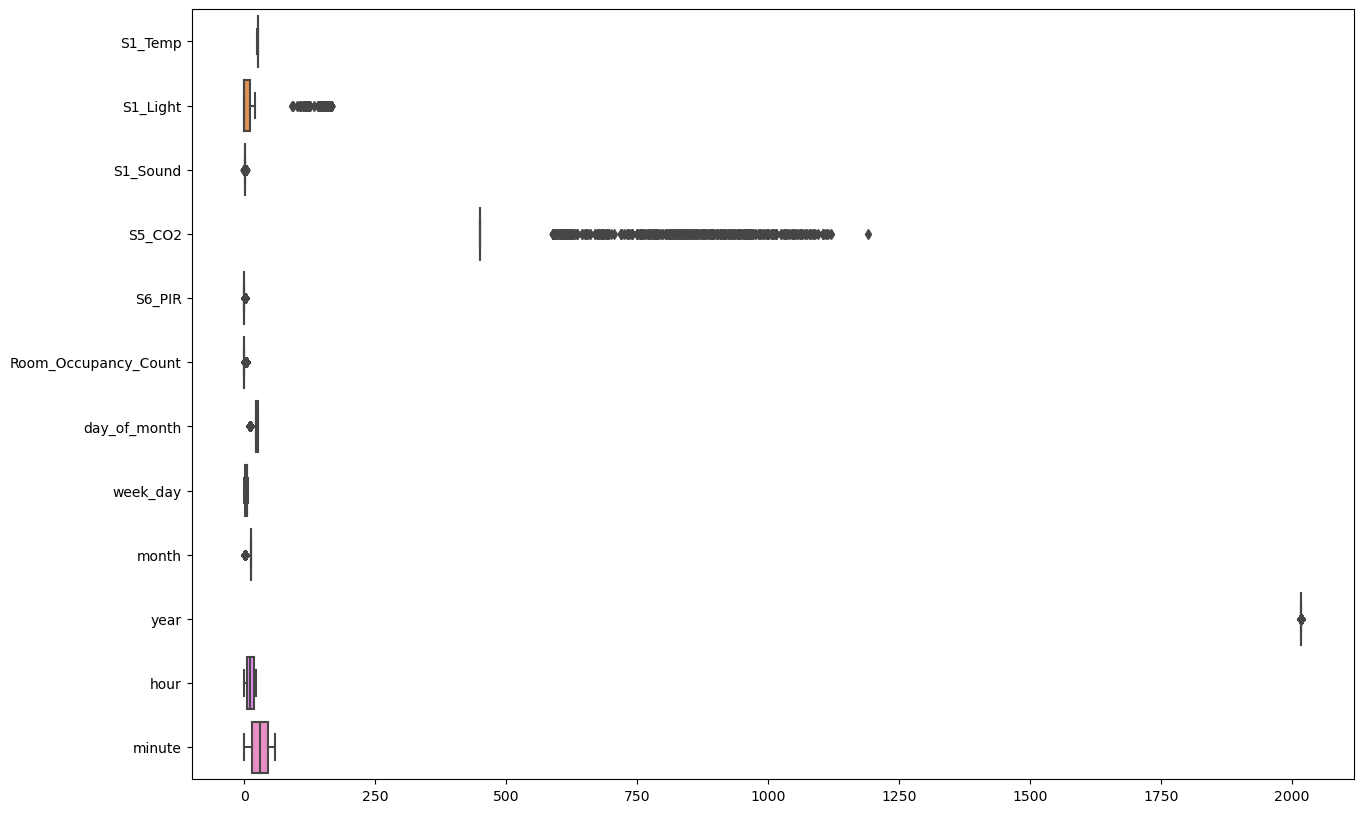

In [47]:
# outliers tratados
plt.figure(figsize= (15,10))
sns.boxplot(data=df,orient="h")

In [56]:
df.to_csv("../input/Occupancy_Estimation_cleaned_outliers.csv", index=False)

# Modelação com outliers tratados

In [49]:
METRICS = {
        "MAE": make_scorer(mean_absolute_error),
        "MSE": make_scorer(mean_squared_error,squared=True),
        "RMSE": make_scorer(mean_squared_error,squared=False),
        "r2_Score": make_scorer(r2_score),
        "RMSLE": make_scorer(mean_squared_log_error,squared=False)
}

X, y = df.drop("Room_Occupancy_Count", axis=1), df["Room_Occupancy_Count"]

## Decision Trees

In [50]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
#Função de kfold com 10 iterações, garante que os resultados são iguais

## DT
dt = DecisionTreeRegressor(max_depth=3, random_state=1234)
scores = cross_validate(dt, X, y, cv=splitter, scoring=METRICS)
dt_scores = pd.DataFrame(scores)
pd.DataFrame(dt_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.007298,0.002828,0.049592,0.046388,0.21421,0.934622,0.095693


In [51]:
# 0	0.008152	0.002607	0.060198	0.061134	0.245313	0.923407	0.10839

## Random Forest

In [52]:
rf = RandomForestRegressor(max_depth=3, random_state=1234)
scores = cross_validate(rf, X, y, cv=splitter, scoring=METRICS)
rf_scores = pd.DataFrame(scores)
pd.DataFrame(rf_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.360998,0.009638,0.050714,0.044551,0.209968,0.9372,0.089815


In [53]:
# 0 0.436026	0.009631	0.062394	0.056071	0.235008	0.929755	0.103187

## Extra Trees

In [54]:
et = ExtraTreesRegressor(max_depth=3, random_state=1234)
scores = cross_validate(et, X, y, cv=splitter, scoring=METRICS)
et_scores = pd.DataFrame(scores)
pd.DataFrame(et_scores.mean()).T

,fit_time,score_time,test_MAE,test_MSE,test_RMSE,test_r2_Score,test_RMSLE
0,0.175293,0.009337,0.088795,0.073196,0.268775,0.896795,0.117914


In [55]:
# 0	0.189558	0.009823	0.100988	0.087753	0.295433	0.890095	0.127621

## Resultados
Como já temos outliers tratados, podemos utilizar métricas menos sensíveis como o R2. Tendo em conta a distribuição dos dados, continuaremos a utiliar o RMSLE, como prioridade.
* Houve melhoria de ambos os parâmetros em todos os modelos, o tratamento de outliers melhorou o desempenho.
* Os melhores resultados são com o Random Forest, logo, realizaremos um processamento individual para esse modelo.

Seguir para o notebook 3.